In [85]:
%pip install catboost
%pip install xgboost
%pip install optuna

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
import re
import math
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy.stats import chi2_contingency, boxcox, skew, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ML utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ML models
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter tuning
import xgboost as xgb
import optuna

In [88]:
def read_excel_data(file_path, sheet_names):
    data_frames = []

    for sheet_name in sheet_names:
      df = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
      data_frames.append(df)

    return data_frames

In [89]:
# Read Excel sheets into DataFrames
sheet_names = ['loan_information', 'Employment', 'Personal_information', 'Other_information']
dfs = read_excel_data("/content/drive/MyDrive/Credit_Risk_Dataset.xlsx", sheet_names)

loan_information = dfs[0]
employment = dfs[1]
personal_information = dfs[2]
other_information = dfs[3]

# Standardize the 'User_id' column names across all DataFrames
employment.rename(columns={'User id': 'User_id'}, inplace=True)
personal_information.rename(columns={'User id': 'User_id'}, inplace=True)

# Merge 'loan_information' and 'employment' DataFrames based on 'User_id'
merged_df = pd.merge(loan_information, employment, on='User_id')

# Merge the previously merged DataFrame with 'personal_information' based on 'User_id'
merged_df = pd.merge(merged_df, personal_information, on='User_id')

# Merge the previously merged DataFrame with 'other_information' based on 'User_id'
merged_df = pd.merge(merged_df, other_information, on='User_id')
df = merged_df
df.to_csv("merged_data.csv", index=False)

## Data Overview

In [90]:
df = pd.read_csv("merged_data.csv")
df.head()

,User_id,Loan Category,Amount,Interest Rate,Tenure(years),Employmet type,Tier of Employment,Industry,Role,Work Experience,...,Home,Pincode,Social Profile,Is_verified,Delinq_2yrs,Total Payement,Received Principal,Interest Received,Number of loans,Defaulter
0,7013527,Consolidation,55884.0,11.84,6,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,...,rent,XX852X,No,NaN,0,1824.150000,971.46,852.69,0,1
1,7014291,Consolidation,55511.0,16.94,4,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,...,mortgage,XX286X,NaN,Source Verified,0,22912.532998,18000.00,4912.53,0,0
2,7014327,Consolidation,12289.0,11.84,6,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,...,own,XX113X,No,NaN,0,7800.440000,4489.76,3310.68,0,1
3,7014304,Credit Card,29324.0,14.71,4,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,...,rent,XX941X,Yes,NaN,0,6672.050000,5212.29,1459.76,0,0
4,7031995,Credit Card,30252.0,14.71,4,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,...,rent,XX913X,No,Verified,0,11793.001345,10000.00,1793.00,0,0


In [91]:
df = df.drop(columns=['Pincode', 'Role', 'Industry', 'User_id'])

df.rename(columns={
    'Employmet type': 'Employment type',
    'Total Payement ': 'Total Payment',
    'Total Income(PA)': 'Total Income',
    'Tenure(years)': 'Loan Tenure'
}, inplace=True)

df['Employment type'] = df['Employment type'].str.replace('Self - Employeed', 'Self Employed')

df.head()

,Loan Category,Amount,Interest Rate,Loan Tenure,Employment type,Tier of Employment,Work Experience,Total Income,Gender,Married,Dependents,Home,Social Profile,Is_verified,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
0,Consolidation,55884.0,11.84,6,Salaried,B,1-2,125000.0,Female,Yes,4,rent,No,NaN,0,1824.150000,971.46,852.69,0,1
1,Consolidation,55511.0,16.94,4,Self Employed,D,10+,61000.0,Female,No,1,mortgage,NaN,Source Verified,0,22912.532998,18000.00,4912.53,0,0
2,Consolidation,12289.0,11.84,6,NaN,NaN,5-10,100000.0,Other,NaN,3,own,No,NaN,0,7800.440000,4489.76,3310.68,0,1
3,Credit Card,29324.0,14.71,4,NaN,NaN,2-3,30000.0,Male,NaN,1,rent,Yes,NaN,0,6672.050000,5212.29,1459.76,0,0
4,Credit Card,30252.0,14.71,4,NaN,NaN,10+,65000.0,Male,NaN,3,rent,No,Verified,0,11793.001345,10000.00,1793.00,0,0


In [92]:
df.describe()

,Amount,Interest Rate,Loan Tenure,Total Income,Dependents,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
count,1.118030e+05,143727.000000,143727.000000,1.437270e+05,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.376458e+05,12.038703,4.514503,7.242256e+04,1.997113,0.276601,10840.882025,8407.001538,2352.729746,0.005573,0.093712
std,1.575427e+05,3.880204,0.874241,5.539328e+04,1.411317,0.789019,8613.421536,7224.396032,2447.759754,0.098785,0.291429
min,0.000000e+00,5.420000,4.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.837950e+04,9.180000,4.000000,4.500000e+04,1.000000,0.000000,4674.775000,3104.160000,841.685000,0.000000,0.000000
50%,7.660300e+04,11.840000,4.000000,6.180000e+04,2.000000,0.000000,8212.410000,6000.000000,1632.240000,0.000000,0.000000
75%,2.054645e+05,14.440000,6.000000,8.600000e+04,3.000000,0.000000,14175.769677,11664.365000,2904.770000,0.000000,0.000000
max,8.000078e+06,23.540000,6.000000,7.141778e+06,4.000000,22.000000,57777.579870,35000.010000,24205.620000,5.000000,1.000000


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143727 entries, 0 to 143726
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Loan Category       143727 non-null  object 
 1   Amount              111803 non-null  float64
 2   Interest Rate       143727 non-null  float64
 3   Loan Tenure         143727 non-null  int64  
 4   Employment type     59085 non-null   object 
 5   Tier of Employment  59085 non-null   object 
 6   Work Experience     143723 non-null  object 
 7   Total Income        143727 non-null  float64
 8   Gender              143727 non-null  object 
 9   Married             95584 non-null   object 
 10  Dependents          143727 non-null  int64  
 11  Home                143727 non-null  object 
 12  Social Profile      95871 non-null   object 
 13  Is_verified         107924 non-null  object 
 14  Delinq_2yrs         143727 non-null  int64  
 15  Total Payment       143727 non-nul

In [94]:
df.describe()

,Amount,Interest Rate,Loan Tenure,Total Income,Dependents,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
count,1.118030e+05,143727.000000,143727.000000,1.437270e+05,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.376458e+05,12.038703,4.514503,7.242256e+04,1.997113,0.276601,10840.882025,8407.001538,2352.729746,0.005573,0.093712
std,1.575427e+05,3.880204,0.874241,5.539328e+04,1.411317,0.789019,8613.421536,7224.396032,2447.759754,0.098785,0.291429
min,0.000000e+00,5.420000,4.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.837950e+04,9.180000,4.000000,4.500000e+04,1.000000,0.000000,4674.775000,3104.160000,841.685000,0.000000,0.000000
50%,7.660300e+04,11.840000,4.000000,6.180000e+04,2.000000,0.000000,8212.410000,6000.000000,1632.240000,0.000000,0.000000
75%,2.054645e+05,14.440000,6.000000,8.600000e+04,3.000000,0.000000,14175.769677,11664.365000,2904.770000,0.000000,0.000000
max,8.000078e+06,23.540000,6.000000,7.141778e+06,4.000000,22.000000,57777.579870,35000.010000,24205.620000,5.000000,1.000000


## Missing Data Analysis

In [95]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

,0
Amount,31924
Employment type,84642
Tier of Employment,84642
Work Experience,4
Married,48143
Social Profile,47856
Is_verified,35803


In [96]:
missing_data_proportion = df.isnull().mean() * 100
missing_data_proportion = missing_data_proportion[missing_data_proportion > 0]
missing_data_proportion = missing_data_proportion.sort_values(ascending=False)
missing_data_proportion_formatted = missing_data_proportion.apply(lambda x: f"{x:.2f}%")
missing_data_proportion_formatted

,0
Employment type,58.89%
Tier of Employment,58.89%
Married,33.50%
Social Profile,33.30%
Is_verified,24.91%
Amount,22.21%
Work Experience,0.00%


In [97]:
num_imputer = SimpleImputer(strategy='median')  # For numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns

# Select numerical and categorical columns
numerical_cols = ['Amount']
categorical_cols = ['Employment type', 'Tier of Employment', 'Married', 'Social Profile', 'Is_verified']

df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [98]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

,0
Work Experience,4


In [99]:
print(df['Work Experience'].unique())
missing_work_exp = df[df['Work Experience'].isnull()]
missing_work_exp

['1-2' '10+' '5-10' '2-3' '3-5' '0' '<1' nan 0]


,Loan Category,Amount,Interest Rate,Loan Tenure,Employment type,Tier of Employment,Work Experience,Total Income,Gender,Married,Dependents,Home,Social Profile,Is_verified,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
2413,Consolidation,300054.0,16.05,6,Salaried,B,NaN,97000.0,Male,No,3,mortgage,No,Not Verified,0,21824.66,11822.51,10002.15,0,0
54119,Credit Card,76603.0,5.98,4,Salaried,A,NaN,30000.0,Male,Yes,3,rent,No,Not Verified,0,10567.84,10000.00,567.84,0,0
125065,Consolidation,16931.0,13.09,4,Salaried,B,NaN,25000.0,Other,Yes,4,own,No,Source Verified,1,2581.35,1825.05,756.30,0,0
130563,Business,61204.0,22.13,6,Salaried,B,NaN,120000.0,Female,Yes,0,mortgage,Yes,Verified,0,31259.83,30000.00,1259.83,0,0


In [100]:
df['Work Experience'].replace(['0', 'nan 0', np.nan], '<1', inplace=True)
df = df.dropna(subset=['Work Experience'])
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

,0


In [101]:
df.describe()

,Amount,Interest Rate,Loan Tenure,Total Income,Dependents,Delinq_2yrs,Total Payment,Received Principal,Interest Received,Number of loans,Defaulter
count,1.437270e+05,143727.000000,143727.000000,1.437270e+05,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.240872e+05,12.038703,4.514503,7.242256e+04,1.997113,0.276601,10840.882025,8407.001538,2352.729746,0.005573,0.093712
std,1.412468e+05,3.880204,0.874241,5.539328e+04,1.411317,0.789019,8613.421536,7224.396032,2447.759754,0.098785,0.291429
min,0.000000e+00,5.420000,4.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.663650e+04,9.180000,4.000000,4.500000e+04,1.000000,0.000000,4674.775000,3104.160000,841.685000,0.000000,0.000000
50%,7.660300e+04,11.840000,4.000000,6.180000e+04,2.000000,0.000000,8212.410000,6000.000000,1632.240000,0.000000,0.000000
75%,1.673170e+05,14.440000,6.000000,8.600000e+04,3.000000,0.000000,14175.769677,11664.365000,2904.770000,0.000000,0.000000
max,8.000078e+06,23.540000,6.000000,7.141778e+06,4.000000,22.000000,57777.579870,35000.010000,24205.620000,5.000000,1.000000


## Feature Distribution and Univariate Analysis

### Categorical and numerical feature analysis

In [102]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")

print("\nNumerical Features:")
print(numerical_features)

print("\nDistinct values for each numerical feature:")
for feature in numerical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    if distinct_values < 6:
        print(f"Values: {unique_values}")

Categorical Features:
['Loan Category', 'Employment type', 'Tier of Employment', 'Work Experience', 'Gender', 'Married', 'Home', 'Social Profile', 'Is_verified']

Distinct values for each categorical feature:
Loan Category: 7 unique values
Values: ['Consolidation' 'Credit Card' 'Home' 'Other ' 'Business' 'Car '
 'Medical ']
Employment type: 2 unique values
Values: ['Salaried' 'Self Employed']
Tier of Employment: 7 unique values
Values: ['B' 'D' 'C' 'A' 'E' 'G' 'F']
Work Experience: 7 unique values
Values: ['1-2' '10+' '5-10' '2-3' '3-5' '<1' 0]
Gender: 3 unique values
Values: ['Female' 'Other' 'Male']
Married: 2 unique values
Values: ['Yes' 'No']
Home: 5 unique values
Values: ['rent' 'mortgage' 'own' 'none' 'other']
Social Profile: 2 unique values
Values: ['No' 'Yes']
Is_verified: 3 unique values
Values: ['Not Verified' 'Source Verified' 'Verified']

Numerical Features:
['Amount', 'Interest Rate', 'Loan Tenure', 'Total Income', 'Dependents', 'Delinq_2yrs', 'Total Payment', 'Received Pr

If a discrete numerical feature has many distinct values (e.g., 0 to 10+ dependents), it can be treated as numerical discrete.
If a discrete numerical feature has few distinct values (e.g., 0 to 4+ dependents), it can be treated as categorical.

Loan Tenure has 2 unique values, Dependents has 5 unique values, Number of loans has 5 unique values and Defaulter has 2 unique values.

The Defaulter variable is a categorical feature since it has two distinct values, 0 and 1, representing whether a user is a defaulter or not. It should be treated as a binary categorical variable, not as a numerical one.

In [103]:
df['Loan Tenure'] = df['Loan Tenure'].astype('category')
df['Dependents'] = df['Dependents'].astype('category')
df['Number of loans'] = df['Number of loans'].astype('category')
df['Defaulter'] = df['Defaulter'].astype('category')

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical Features:")
print(categorical_features)

numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical Features:")
print(numerical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")


Categorical Features:
['Loan Category', 'Loan Tenure', 'Employment type', 'Tier of Employment', 'Work Experience', 'Gender', 'Married', 'Dependents', 'Home', 'Social Profile', 'Is_verified', 'Number of loans', 'Defaulter']

Numerical Features:
['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

Distinct values for each categorical feature:
Loan Category: 7 unique values
Values: ['Consolidation' 'Credit Card' 'Home' 'Other ' 'Business' 'Car '
 'Medical ']
Loan Tenure: 2 unique values
Values: [6, 4]
Categories (2, int64): [4, 6]
Employment type: 2 unique values
Values: ['Salaried' 'Self Employed']
Tier of Employment: 7 unique values
Values: ['B' 'D' 'C' 'A' 'E' 'G' 'F']
Work Experience: 7 unique values
Values: ['1-2' '10+' '5-10' '2-3' '3-5' '<1' 0]
Gender: 3 unique values
Values: ['Female' 'Other' 'Male']
Married: 2 unique values
Values: ['Yes' 'No']
Dependents: 5 unique values
Values: [4, 1, 3, 0, 2]
Categories (5, in

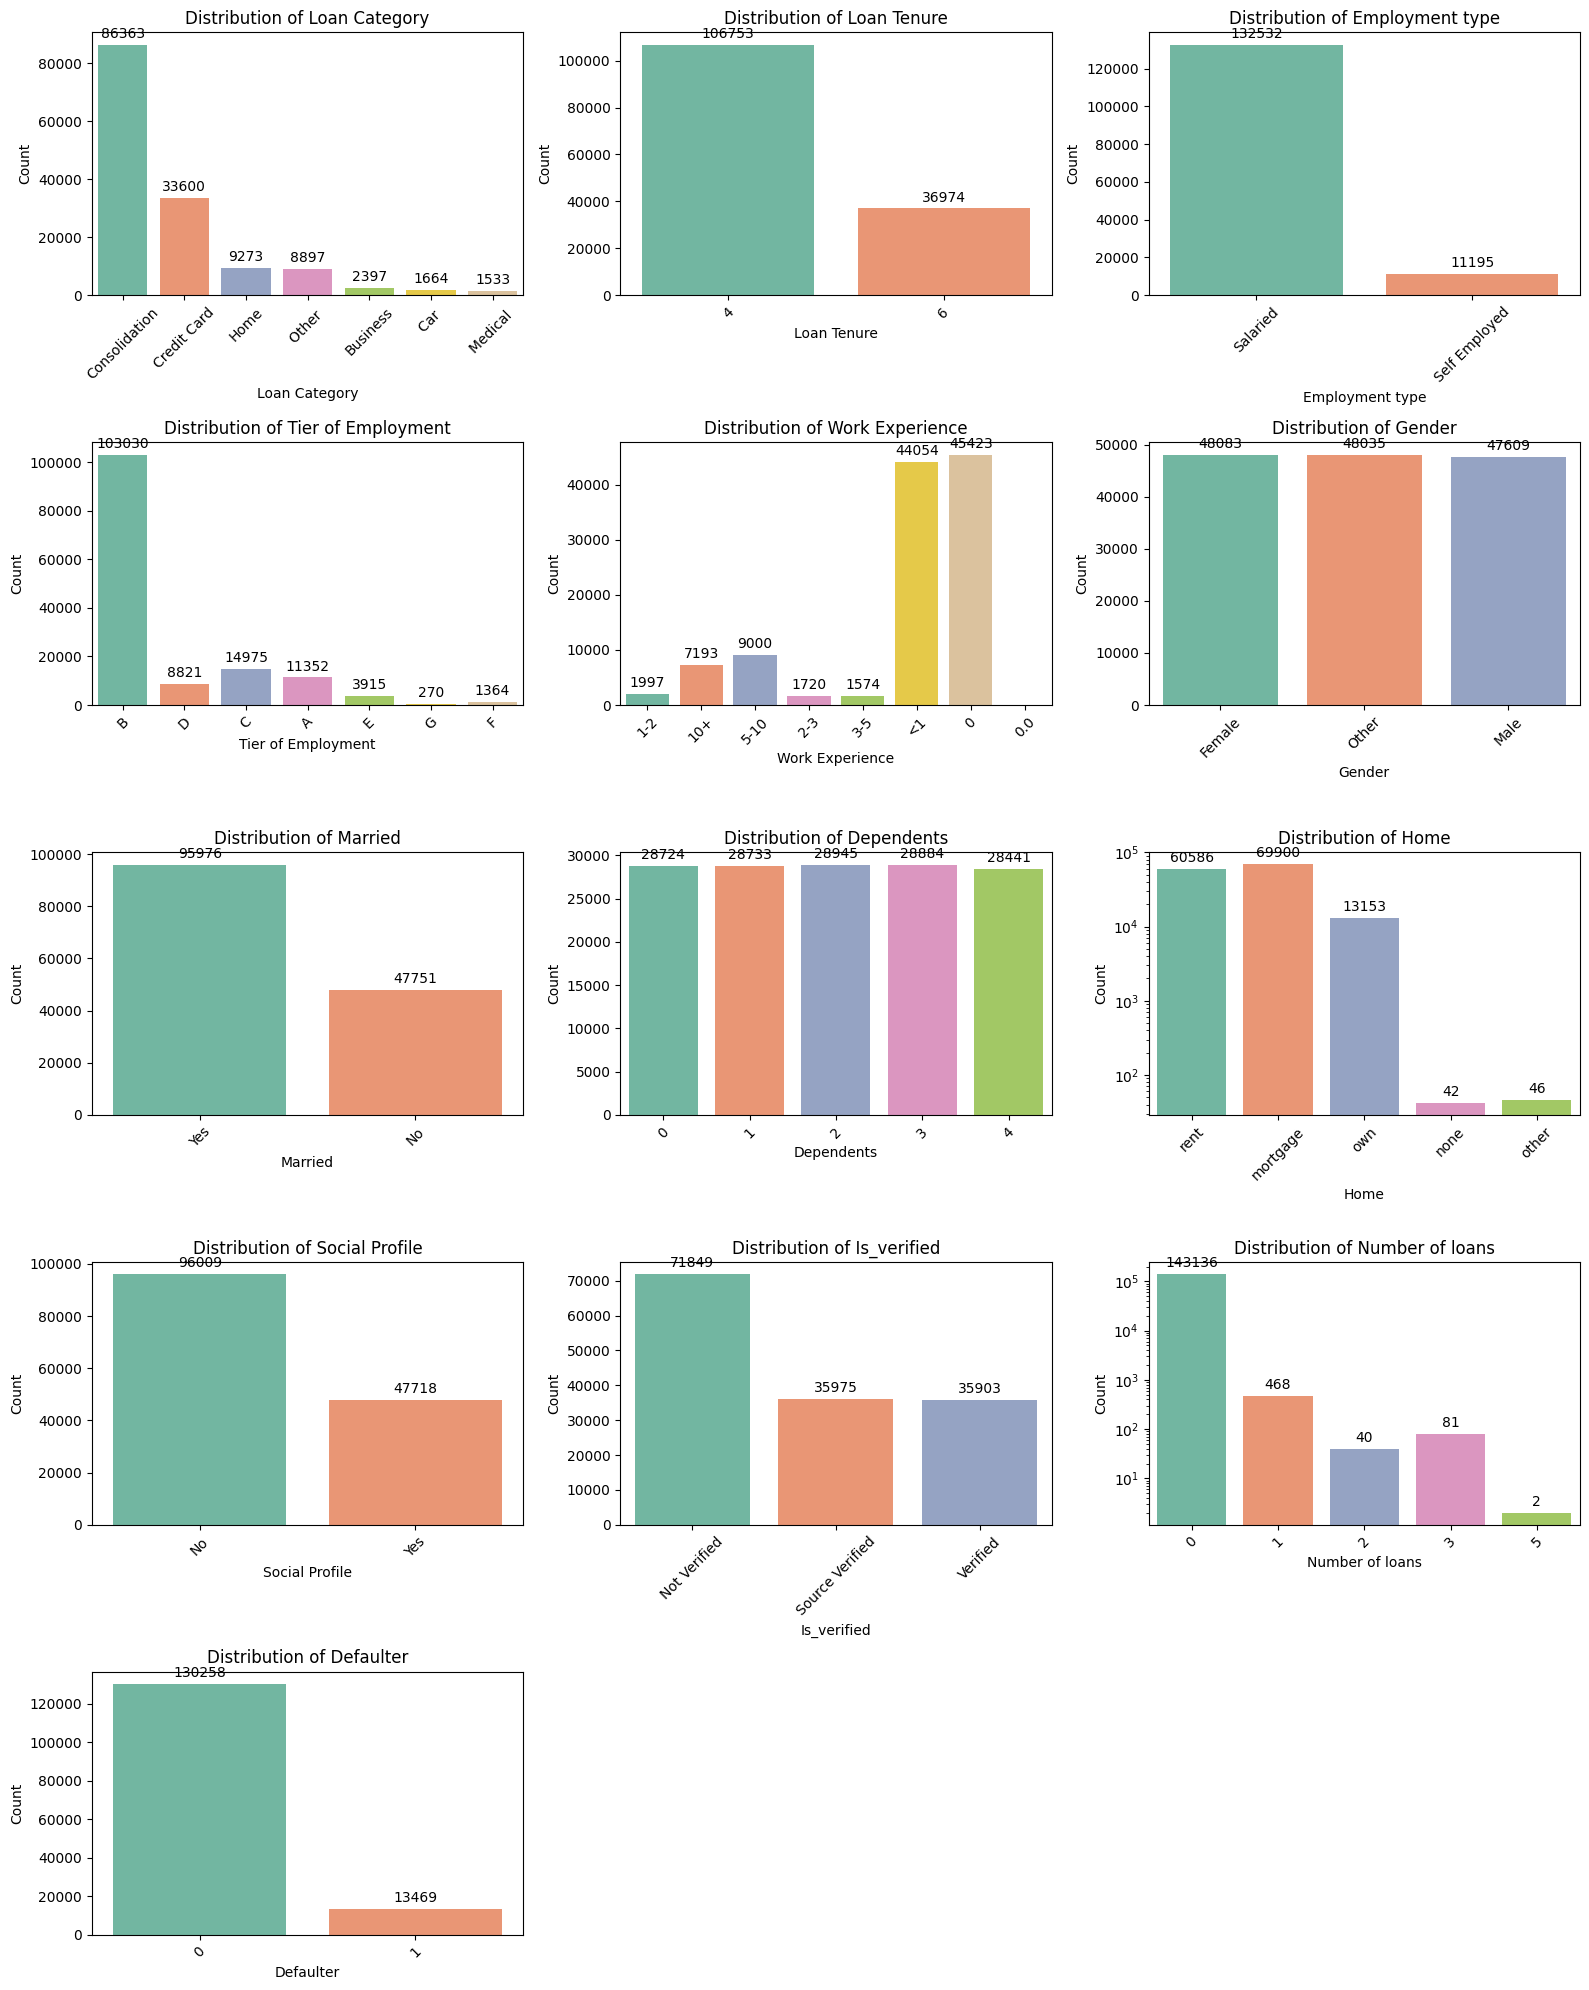

In [104]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type',
                        'Tier of Employment', 'Work Experience', 'Gender',
                        'Married', 'Dependents', 'Home', 'Social Profile',
                        'Is_verified', 'Number of loans', 'Defaulter']

cols = 3
num_features = len(categorical_features)
rows = (num_features // cols) + 1 if num_features % cols != 0 else num_features // cols

plt.figure(figsize=(16, 4 * rows))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(rows, cols, i)

    if feature in ['Number of loans', 'Home']:
        ax = sns.countplot(data=df, x=feature, palette='Set2')
        plt.yscale('log')
    else:
        ax = sns.countplot(data=df, x=feature, palette='Set2')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

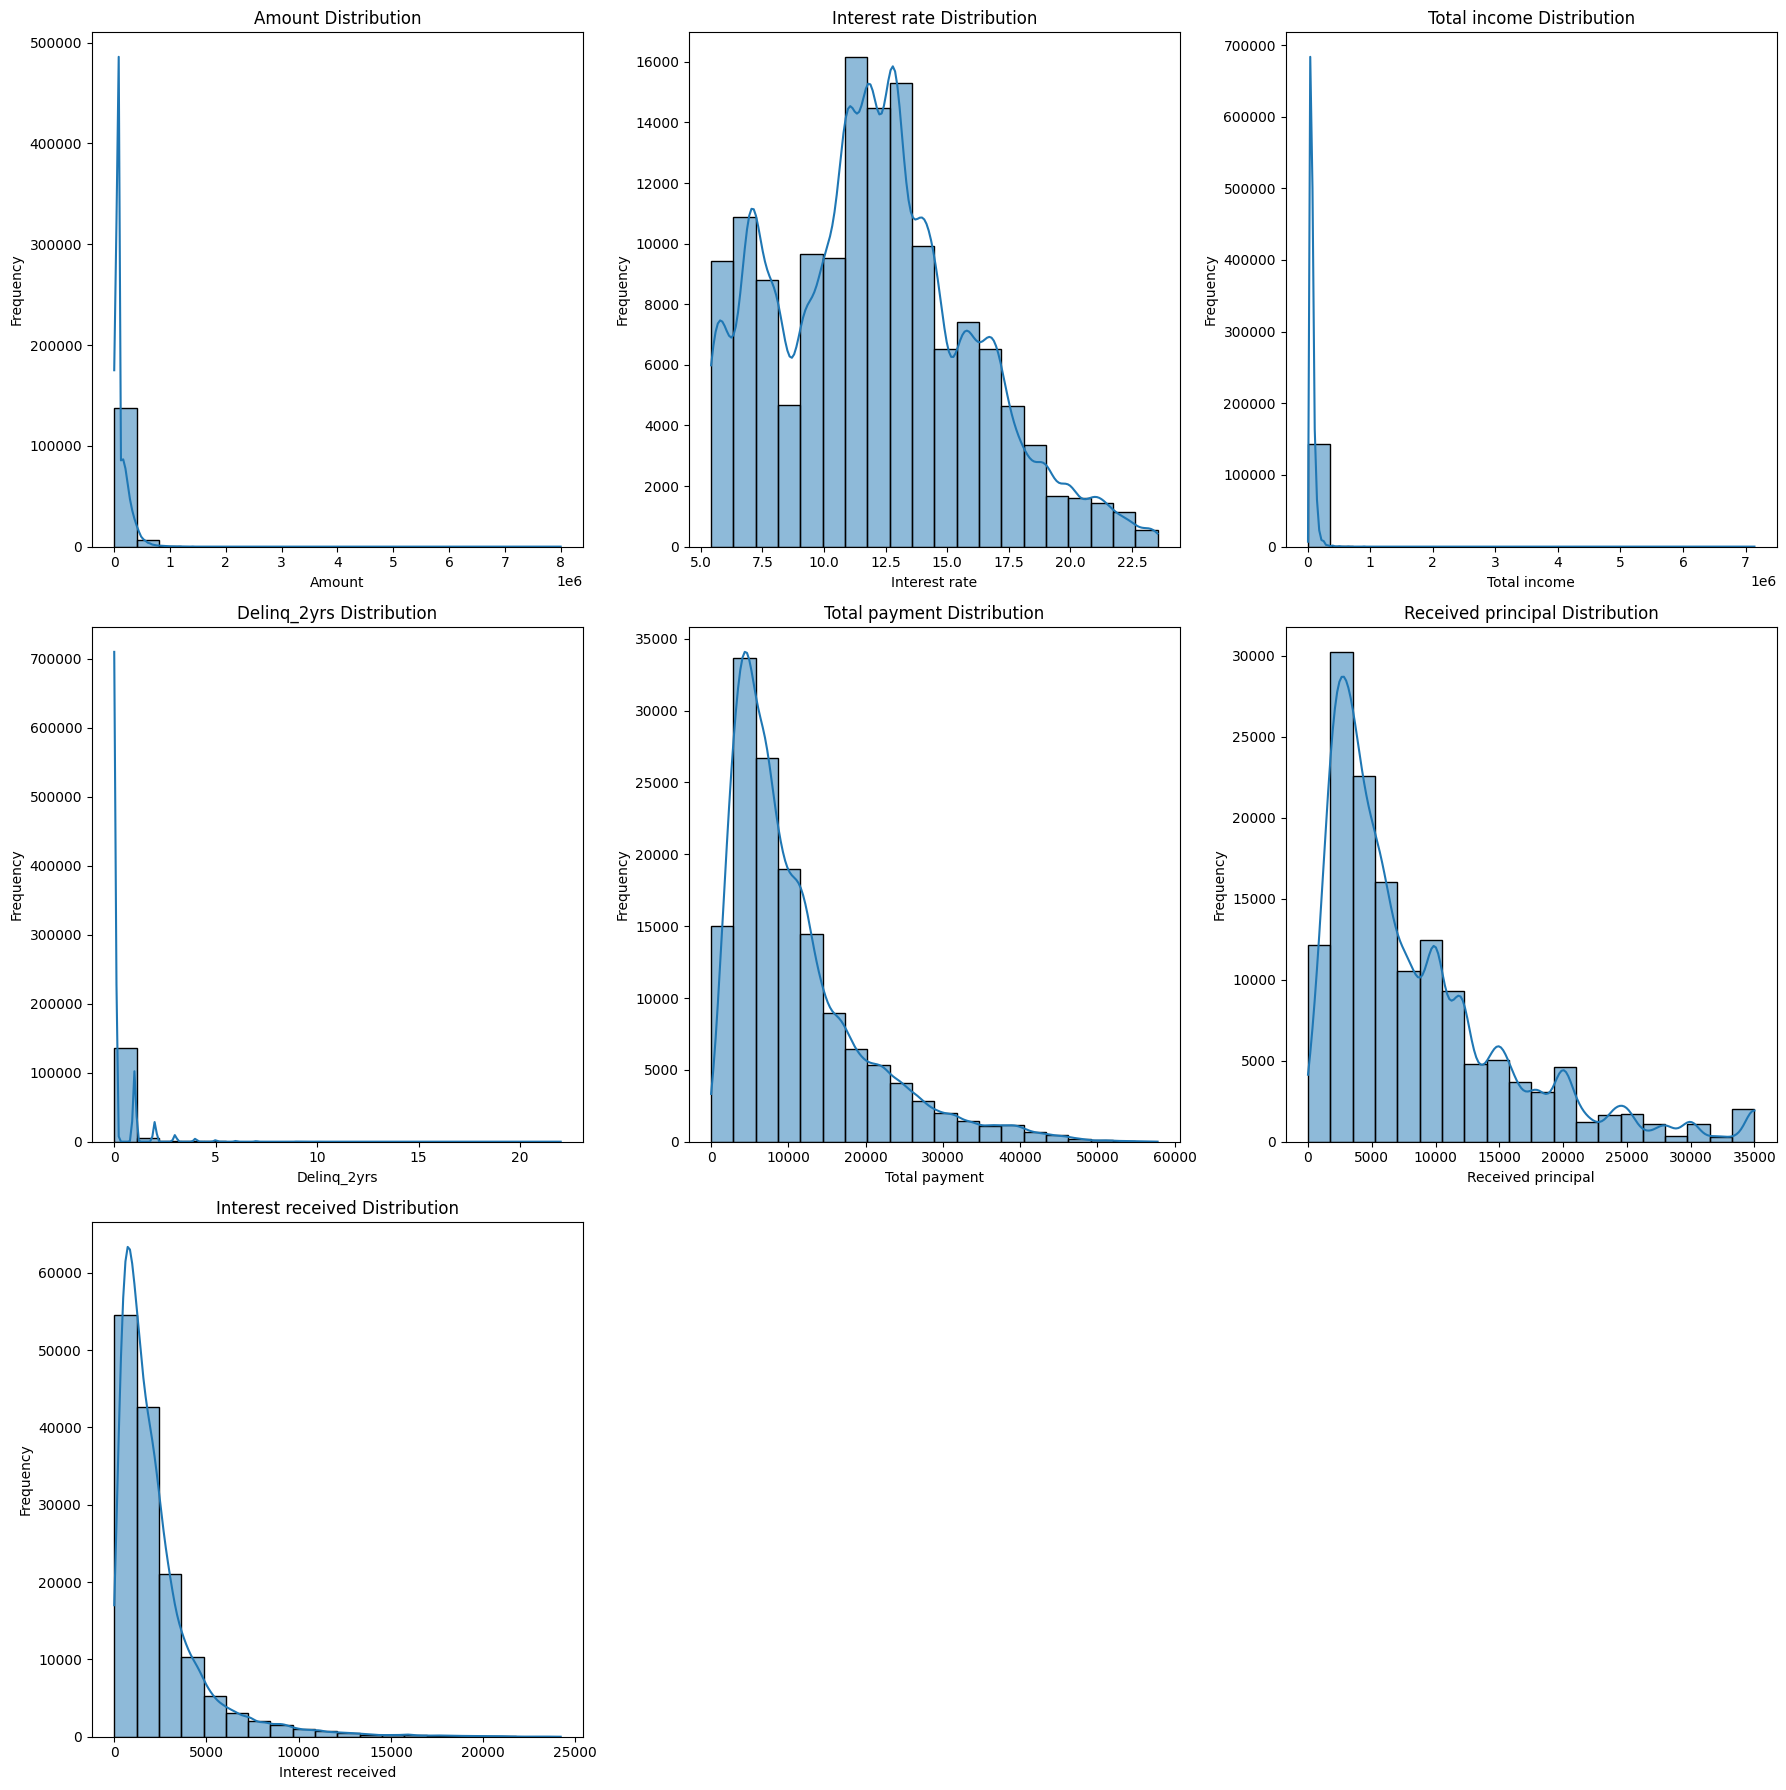

In [105]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

num_features = len(numerical_features)
cols = 3
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axs = axs.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], bins=20, kde=True, ax=axs[i])
    axs[i].set_title(f'{feature.capitalize()} Distribution')
    axs[i].set_xlabel(feature.capitalize())
    axs[i].set_ylabel('Frequency')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Shape Analysis (Skewness)

In [106]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

skewness = df[numerical_features].skew()
skewness

,0
Amount,4.878249
Interest Rate,0.357040
Total Income,28.021331
Delinq_2yrs,5.460526
Total Payment,1.567516
Received Principal,1.521783
Interest Received,2.835966


Highly Skewed Features: Amount,Total Income, Delinq_2yrs, Interest Received
Moderate Skewness: Total Payment, Received Principal

In [107]:
# Apply log transformations
df['Amount'] = np.log1p(df['Amount'])  # First log1p transformation for Amount
df['Total Income'] = np.log1p(df['Total Income'])
df['Interest Received'] = np.log1p(df['Interest Received'])
df['Delinq_2yrs'] = np.log1p(df['Delinq_2yrs'])

# Apply square root transformations for moderately skewed features
df['Total Payment'] = np.sqrt(df['Total Payment'])
df['Received Principal'] = np.sqrt(df['Received Principal'])

# Apply reflection transformation (log with reflection) for negative skewness
df['Interest Received'] = np.log(np.max(df['Interest Received']) - df['Interest Received'] + 1)
df['Amount'] = np.log(np.max(df['Amount']) - df['Amount'] + 1)

# Apply Box-Cox transformation for highly skewed features
Q1 = df['Delinq_2yrs'].quantile(0.25)
Q3 = df['Delinq_2yrs'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = df['Delinq_2yrs'].quantile(0.05)
upper_bound = df['Delinq_2yrs'].quantile(0.95)
df['Delinq_2yrs'] = np.where(df['Delinq_2yrs'] > upper_bound, upper_bound, df['Delinq_2yrs'])
df['Delinq_2yrs'] = np.where(df['Delinq_2yrs'] < lower_bound, lower_bound, df['Delinq_2yrs'])
df['Delinq_2yrs'] = np.log1p(df['Delinq_2yrs'])

In [108]:
skewness = df[numerical_features].skew()
skewness

,0
Amount,-0.116427
Interest Rate,0.357040
Total Income,0.218395
Delinq_2yrs,1.855522
Total Payment,0.683249
Received Principal,0.669793
Interest Received,-0.487019


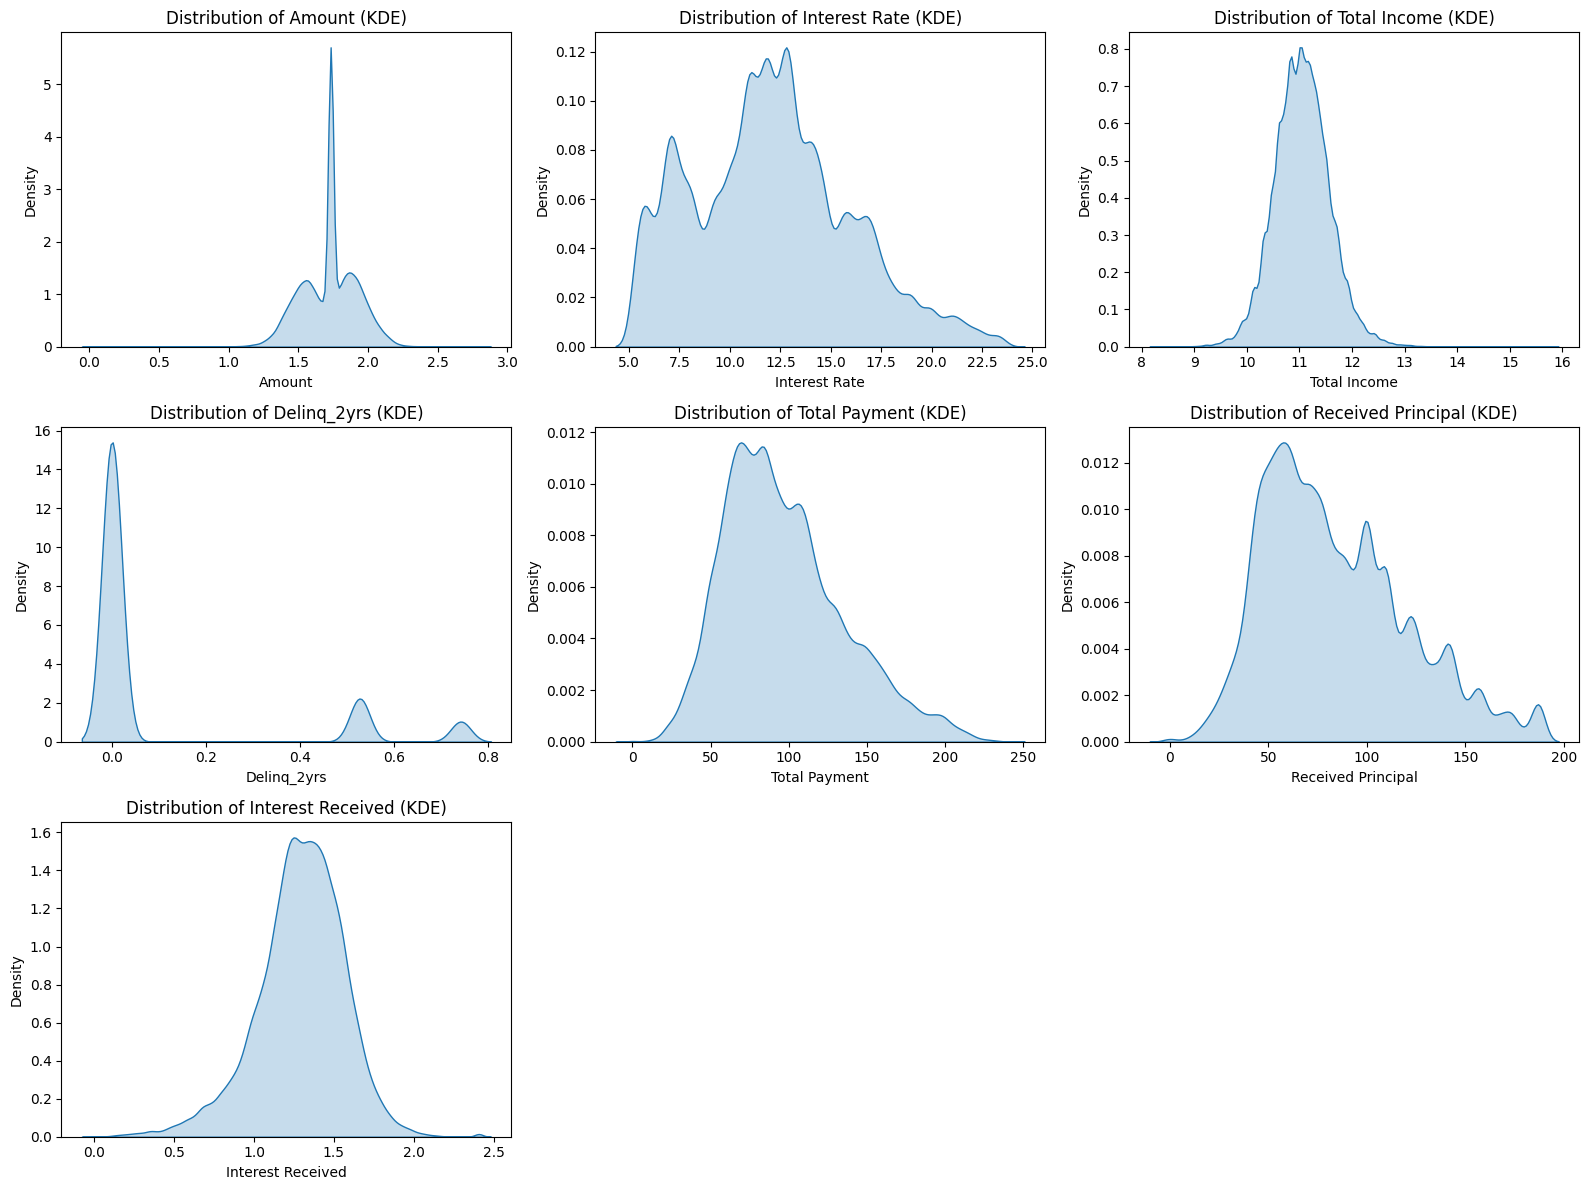

In [109]:
cols = 3
num_features = len(numerical_features)
rows = (num_features // cols) + 1 if num_features % cols != 0 else num_features // cols
plt.figure(figsize=(16, 4 * rows))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(df[feature], shade=True)
    plt.title(f'Distribution of {feature} (KDE)')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Outlier Analysis

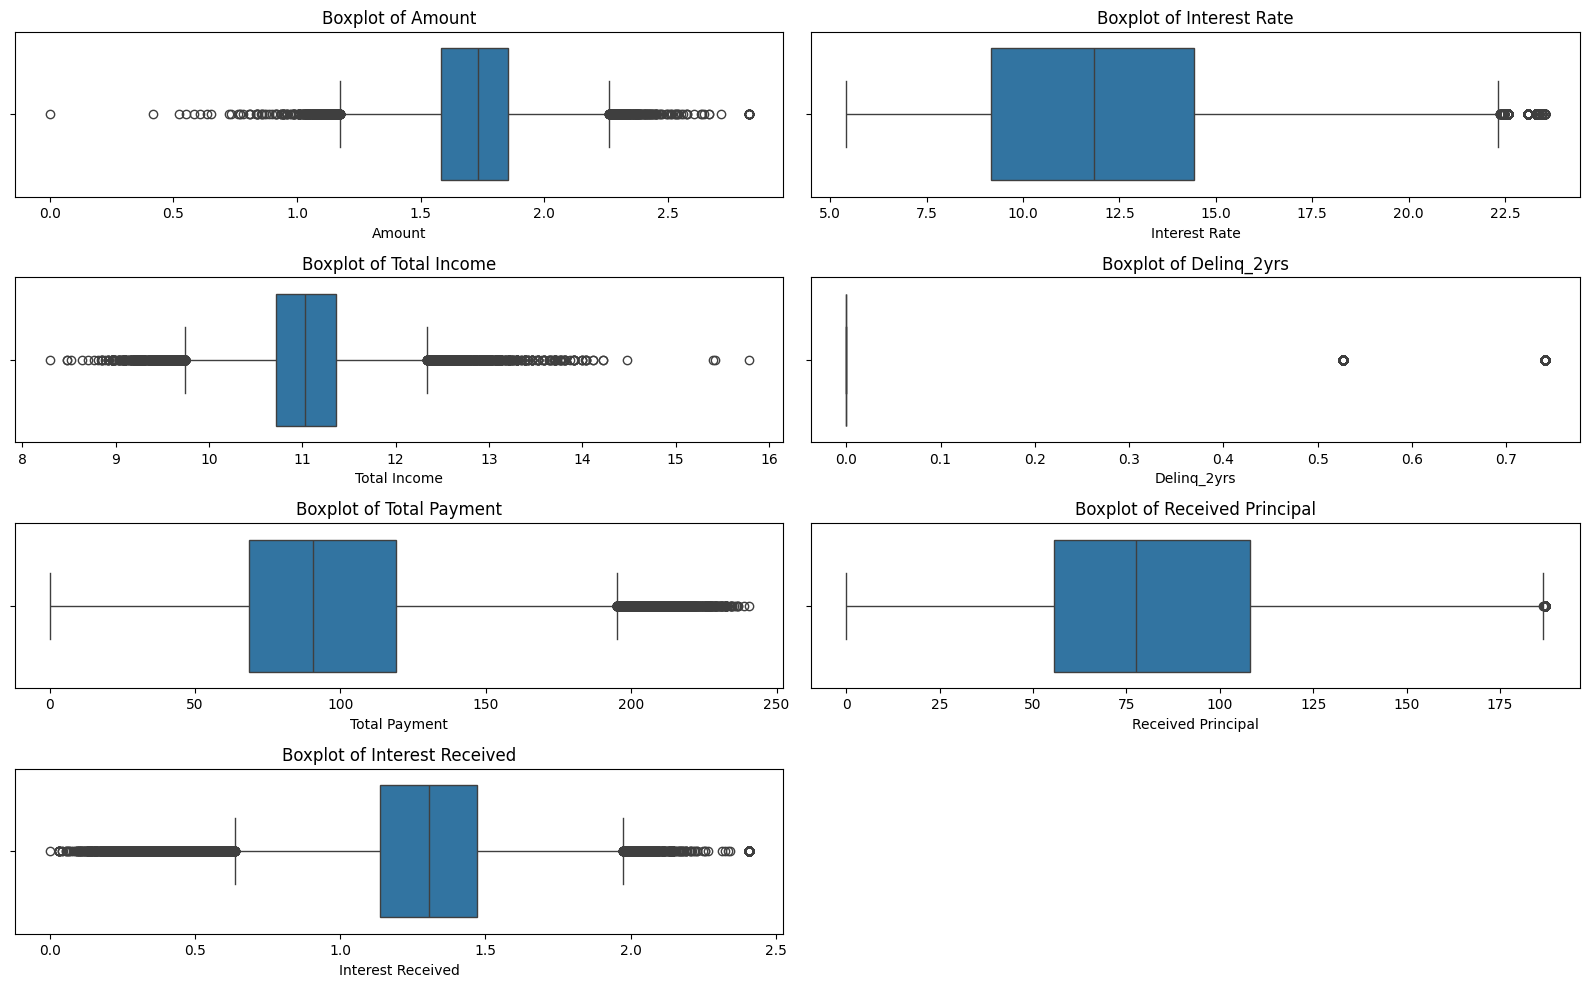

In [110]:
plt.figure(figsize=(16, 12))
for i, feature in enumerate(['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received'], 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [111]:
def calculate_iqr_bounds(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

for feature in ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']:
    lower, upper = calculate_iqr_bounds(df, feature)
    print(f"{feature} has bounds - Lower Bound: {lower}, Upper Bound: {upper}")

Amount has bounds - Lower Bound: 1.175160107965279, Upper Bound: 2.2615105568038385
Interest Rate has bounds - Lower Bound: 1.29, Upper Bound: 22.33
Total Income has bounds - Lower Bound: 9.742928672206894, Upper Bound: 12.333625521595891
Delinq_2yrs has bounds - Lower Bound: 0.0, Upper Bound: 0.0
Total Payment has bounds - Lower Bound: -7.662246255468176, Upper Bound: 195.0966138176517
Received Principal has bounds - Lower Bound: -22.71506176343709, Upper Bound: 186.43174028986212
Interest Received has bounds - Lower Bound: 0.6365776438492535, Upper Bound: 1.9731968319571256


In [112]:
# cap outliers
def cap_outliers(df, column):
    lower_bound, upper_bound = calculate_iqr_bounds(df, column)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# remove rows with negative values below the lower bound
def remove_negative_values(df, columns):
    for column in columns:
        lower_bound, _ = calculate_iqr_bounds(df, column)
        df = df[df[column] >= lower_bound]
    return df

# features to apply outlier capping
capping_features = ['Amount', 'Total Income', 'Total Payment', 'Received Principal', 'Interest Received']

# features where negative values below the lower bound are invalid
features_with_invalid_negatives = ['Total Payment', 'Received Principal']

for feature in capping_features:
    df = cap_outliers(df, feature)

df = remove_negative_values(df, features_with_invalid_negatives)

In [113]:
df[numerical_features].describe()

,Amount,Interest Rate,Total Income,Delinq_2yrs,Total Payment,Received Principal,Interest Received
count,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000,143727.000000
mean,1.721249,12.038703,11.039959,0.103734,96.671791,84.089372,1.292836
std,0.194252,3.880204,0.507444,0.229547,37.729115,36.509769,0.262063
min,1.175160,5.420000,9.742929,0.000000,0.000000,0.000000,0.636578
25%,1.582542,9.180000,10.714440,0.000000,68.372326,55.714989,1.137810
50%,1.731400,11.840000,11.031675,0.000000,90.622348,77.459667,1.307267
75%,1.854129,14.440000,11.362114,0.000000,119.062041,108.001690,1.471965
max,2.261511,23.540000,12.333626,0.741276,195.096614,186.431740,1.973197


## Class Imbalance Analysis

Target Feature Distribution Balance:
Non-default (0): 130258 (90.63%)
Default (1): 13469 (9.37%)


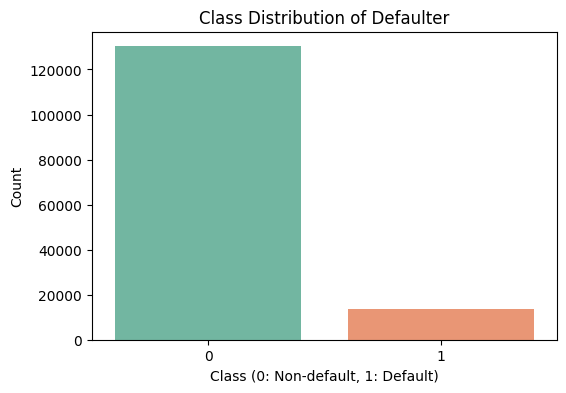

In [114]:
class_counts = df['Defaulter'].value_counts()
class_percentages = class_counts / class_counts.sum() * 100

print("Target Feature Distribution Balance:")
print(f"Non-default (0): {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"Default (1): {class_counts[1]} ({class_percentages[1]:.2f}%)")

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution of Defaulter")
plt.xlabel("Class (0: Non-default, 1: Default)")
plt.ylabel("Count")
plt.show()

The dataset has a significant imbalance, with the non-default class dominating the default class which is common in credit or loan default datasets.

In [115]:
# copy for SMOTE purposes
df_smote = df.copy()
categorical_columns = df_smote.select_dtypes(include=['object', 'category']).columns
# Convert all categorical columns to strings to ensure uniform data types
for column in categorical_columns:
    df_smote[column] = df_smote[column].astype(str)

label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df_smote[column] = label_encoders[column].fit_transform(df_smote[column])

X_smote = df_smote.drop('Defaulter', axis=1)  # Features
y_smote = df_smote['Defaulter']  # Target

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

print("Class distribution after SMOTE:")
y_resampled.value_counts()

Class distribution after SMOTE:


,count
Defaulter,
1,130258
0,130258


## Binvariate Analysis

### Numerical Features Correlation analysis

Pearson Correlation Matrix:
                      Amount  Interest Rate  Total Income  Delinq_2yrs  \
Amount              1.000000       0.067822     -0.472455    -0.089013   
Interest Rate       0.067822       1.000000     -0.067585     0.069311   
Total Income       -0.472455      -0.067585      1.000000     0.093780   
Delinq_2yrs        -0.089013       0.069311      0.093780     1.000000   
Total Payment      -0.196090       0.176565      0.359840    -0.030902   
Received Principal -0.170252       0.024338      0.325349    -0.043525   
Interest Received   0.178215      -0.487585     -0.295583    -0.023277   

                    Total Payment  Received Principal  Interest Received  
Amount                  -0.196090           -0.170252           0.178215  
Interest Rate            0.176565            0.024338          -0.487585  
Total Income             0.359840            0.325349          -0.295583  
Delinq_2yrs             -0.030902           -0.043525          -0.023277  
Tota

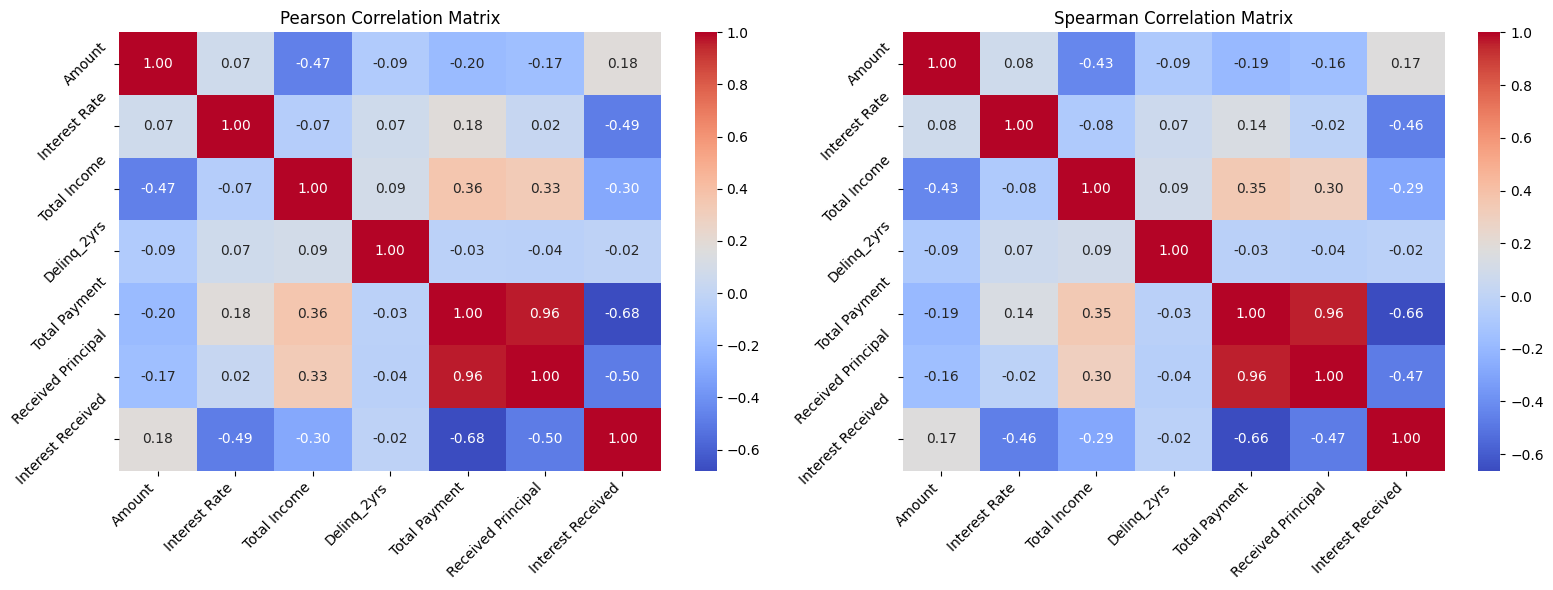

In [116]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']

numerical_df = df[numerical_features]
pearson_corr_matrix = numerical_df.corr(method='pearson')
spearman_corr_matrix = numerical_df.corr(method='spearman')

print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

print("\nSpearman Correlation Matrix:")
print(spearman_corr_matrix)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson Correlation Heatmap
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45)

# Spearman Correlation Heatmap
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Amount vs. Total Income: High negative correlation. This indicates that as Total Income increases, the loan Amount tends to decrease.

Interest Rate vs. Interest Received: Strong negative correlation. Higher Interest Rate results in lower Interest Received, possibly because higher interest rates might discourage larger loans or longer terms.

Total Payment vs. Received Principal: Very high positive correlation. Received Principal makes up a large portion of Total Payment.

Total Payment vs. Interest Received: Strong negative correlation. As Interest Received increases, Total Payment decreases, possibly due to the structure of the loan and its repayment terms.

Linear vs. Monotonic Relationships: In most cases, the Pearson and Spearman correlations are similar in sign and magnitude, suggesting that the relationships between features are both linear and monotonic. This consistency suggests the relationships can be captured well by both linear models and tree-based models.

Pearson Correlation with Target:
Amount                0.031327
Interest Rate         0.169082
Total Income         -0.060564
Delinq_2yrs          -0.015765
Total Payment        -0.165847
Received Principal   -0.246399
Interest Received     0.021868
Name: Defaulter, dtype: float64

Spearman Correlation with Target:
Amount                0.027413
Interest Rate         0.165307
Total Income         -0.061563
Delinq_2yrs          -0.015480
Total Payment        -0.165265
Received Principal   -0.253068
Interest Received     0.023361
Name: Defaulter, dtype: float64


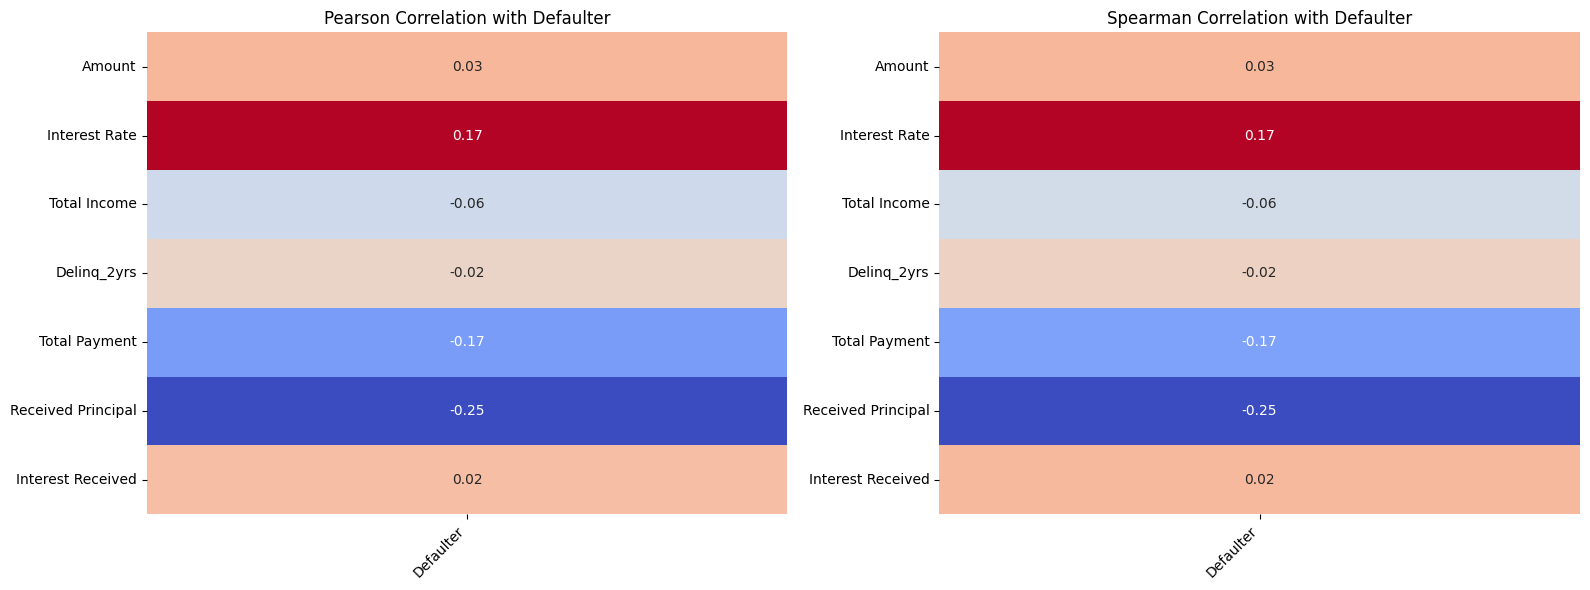

In [117]:
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Total Payment', 'Received Principal', 'Interest Received']
numerical_df = df[numerical_features + ['Defaulter']]

# Compute Pearson and Spearman correlations with the target (Defaulter)
pearson_corr_with_target = numerical_df.corr(method='pearson')['Defaulter'].drop('Defaulter')
spearman_corr_with_target = numerical_df.corr(method='spearman')['Defaulter'].drop('Defaulter')

print("Pearson Correlation with Target:")
print(pearson_corr_with_target)

print("\nSpearman Correlation with Target:")
print(spearman_corr_with_target)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(pearson_corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0], cbar=False)
axes[0].set_title('Pearson Correlation with Defaulter')
axes[0].set_xticklabels(['Defaulter'], rotation=45, ha='right')
axes[0].set_yticklabels(pearson_corr_with_target.index, rotation=0)

sns.heatmap(spearman_corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1], cbar=False)
axes[1].set_title('Spearman Correlation with Defaulter')
axes[1].set_xticklabels(['Defaulter'], rotation=45, ha='right')
axes[1].set_yticklabels(spearman_corr_with_target.index, rotation=0)

plt.tight_layout()
plt.show()

Received Principal has a moderate negative correlation with the target. This suggests that a higher Received Principal is associated with a lower likelihood of default. Borrowers who repay more of the principal amount tend to have a lower chance of default.

Total Payment has a negative correlation with the target, implying that borrowers who have made higher total payments are less likely to default.

## Multicollinearity Check (VIF)

In [118]:
X = df[numerical_features].assign(const=1)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

              Feature          VIF
0              Amount     1.305110
1       Interest Rate     1.627341
2        Total Income     1.486142
3         Delinq_2yrs     1.027047
4       Total Payment    65.038492
5  Received Principal    47.146219
6   Interest Received     5.715856
7               const  1324.047447


VIF > 10: Indicates high multicollinearity
VIF > 5: Indicates moderate multicollinearity
VIF < 1.5: Indicates low multicollinearity, which is acceptable

Total Payment and Received Principal have very high VIF values, indicating strong multicollinearity supported by the previous correlation matrix analysis. The next step is to combine them into a new feature `Payment_to_Principal_Ratio`

## Feature Engineering and Selection

In [119]:
df['Payment_to_Principal_Ratio'] = df['Total Payment'] / (df['Received Principal'] + 1)
df = df.drop(columns=['Total Payment', 'Received Principal'])

The newly created feature, `Payment_to_Principal_Ratio`, should capture the relevant information from both Total Payment and Received Principal, reducing redundancy in the model.

In [120]:
numerical_df = df.select_dtypes(include=[np.number])
numerical_df['const'] = 1

vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_df.columns

vif_data['VIF'] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]
vif_data

,Feature,VIF
0,Amount,1.302498
1,Interest Rate,1.445164
2,Total Income,1.433412
3,Delinq_2yrs,1.021226
4,Interest Received,1.550293
5,Payment_to_Principal_Ratio,1.014926
6,const,1195.491255


### Categorical Features Chi-Square Test

In [121]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type',
                        'Tier of Employment', 'Work Experience', 'Gender',
                        'Married', 'Dependents', 'Home', 'Social Profile',
                        'Is_verified', 'Number of loans']
target_variable = 'Defaulter'

df[categorical_features + [target_variable]] = df[categorical_features + [target_variable]].astype(str)
chi2_results = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'p-value', 'Test Statistic', 'Degrees of Freedom'])

for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        feature1 = categorical_features[i]
        feature2 = categorical_features[j]

        contingency_table = pd.crosstab(df[feature1], df[feature2])
        chi2, p, dof, ex = chi2_contingency(contingency_table)

        temp_df = pd.DataFrame({
            'Feature 1': [feature1],
            'Feature 2': [feature2],
            'p-value': [p],
            'Test Statistic': [chi2],
            'Degrees of Freedom': [dof]
        })
        chi2_results = pd.concat([chi2_results, temp_df], ignore_index=True)

print("Chi-square test between all pairs of features:")
chi2_results

Chi-square test between all pairs of features:


,Feature 1,Feature 2,p-value,Test Statistic,Degrees of Freedom
0,Loan Category,Loan Tenure,4.064223e-232,1089.417090,6
1,Loan Category,Employment type,6.894245e-33,164.408429,6
2,Loan Category,Tier of Employment,3.773445e-273,1410.586939,36
3,Loan Category,Work Experience,1.839875e-301,1566.864636,42
4,Loan Category,Gender,1.139944e-02,25.815030,12
...,...,...,...,...,...
61,Home,Is_verified,5.356346e-01,7.009254,8
62,Home,Number of loans,9.867352e-01,6.120975,16
63,Social Profile,Is_verified,2.186715e-03,12.250710,2
64,Social Profile,Number of loans,2.760081e-01,5.111893,4


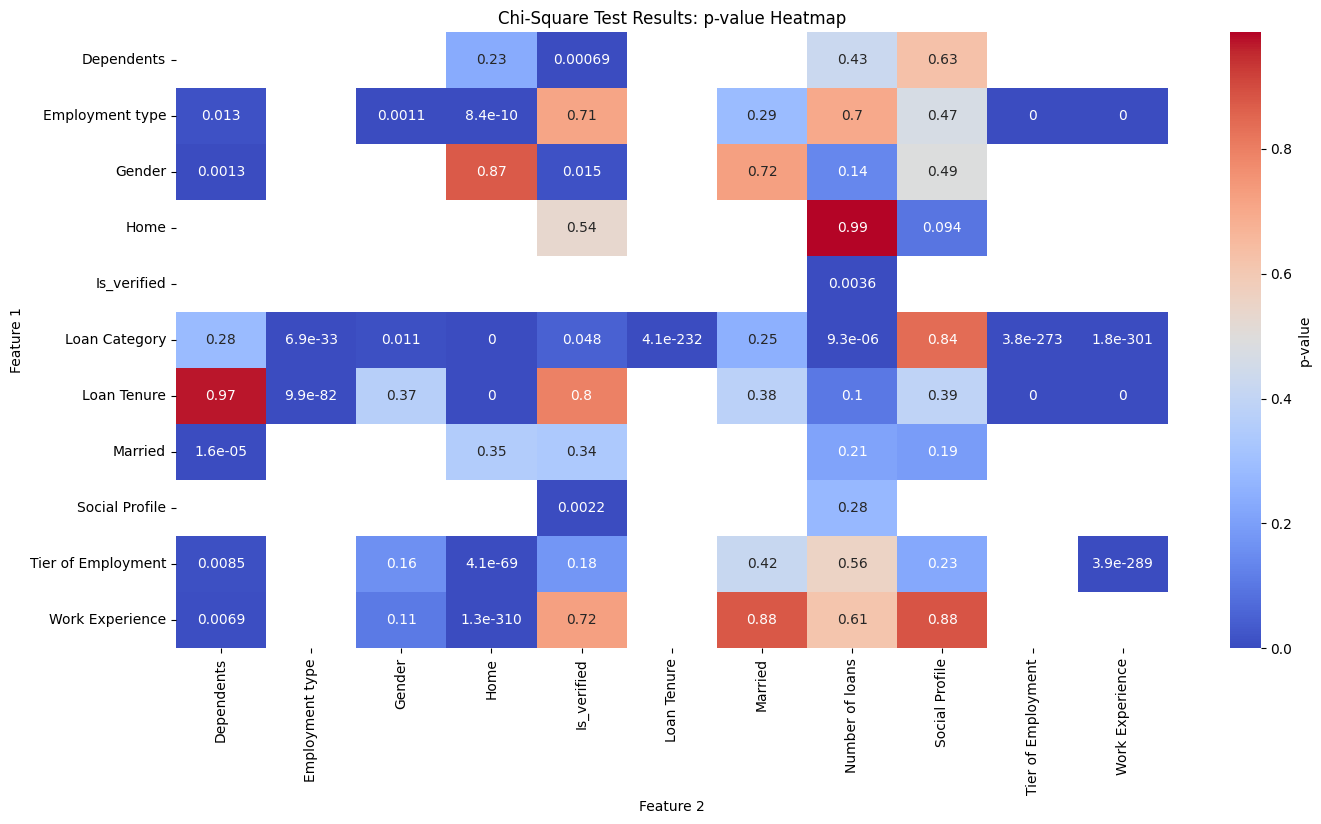

In [122]:
heatmap_data = chi2_results.pivot(index="Feature 1", columns="Feature 2", values="p-value")
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'p-value'})
plt.title('Chi-Square Test Results: p-value Heatmap')
plt.show()

Pairs with very low p-values suggest strong associations, meaning these features are likely correlated
Pairs with higher p-values suggest that the features are likely independent.

Loan category (e.g., consolidation, credit card, home) is significantly correlated with other employment-related features. For example, individuals with certain loan types may tend to fall into specific employment categories or have certain work experience ranges.

Employment type (whether a person is salaried or self-employed) is highly correlated with the tier of employment and work experience. This makes sense because people in higher-tier employment are likely to have more work experience, and salaried employees might dominate certain tiers.

Loan tenure (the loan duration) shows a strong relationship with verification status and the number of loans. This could indicate that longer-tenure loans tend to go through more rigorous verification processes, or borrowers with multiple loans have shorter tenures.

Work Experience shows a strong correlation with Employment Type and Tier of Employment as those with more experience tend to hold higher-tier employment roles.

In [123]:
chi2_results_target = pd.DataFrame(columns=['Feature', 'p-value', 'Test Statistic', 'Degrees of Freedom'])

# Chi-square test between each feature and the target variable
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df[target_variable])
    chi2, p, dof, ex = chi2_contingency(contingency_table)

    temp_df = pd.DataFrame({
        'Feature': [feature],
        'p-value': [p],
        'Test Statistic': [chi2],
        'Degrees of Freedom': [dof]
    })
    chi2_results_target = pd.concat([chi2_results_target, temp_df], ignore_index=True)

print("\nChi-square test between each feature and the target variable:")
chi2_results_target


Chi-square test between each feature and the target variable:


,Feature,p-value,Test Statistic,Degrees of Freedom
0,Loan Category,3.343784e-126,599.274583,6
1,Loan Tenure,1.001395e-33,146.515688,1
2,Employment type,6.293559e-90,404.327539,1
3,Tier of Employment,0.000000e+00,1515.629942,6
4,Work Experience,0.000000e+00,4825.193895,7
5,Gender,6.115570e-01,0.983494,2
6,Married,9.027276e-01,0.014937,1
7,Dependents,3.418652e-02,10.401128,4
8,Home,3.083836e-43,205.049592,4
9,Social Profile,2.589808e-01,1.274197,1


Strong relationship between features and target feature:

Loan categories (e.g., consolidation, credit card, home) significantly impact the likelihood of default. Borrowers with certain loan types may be more or less likely to default, which aligns with different risk profiles for various loan categories.

The length of time over which a loan is repaid (eg: short-term vs. long-term loans) is also significantly associated with default risk. Long-term loans might carry higher risk.

Employment type (salaried vs. self-employed) has a significant impact on default rates. Self-employed individuals may be more prone to default due to potentially unstable income.

The employment tier (e.g., lower-tier vs. higher-tier jobs) is highly related to default risk. Borrowers in lower employment tiers may struggle more with repayment.

Work experience is strongly correlated with default risk. Borrowers with less work experience (e.g., early career individuals) might be at a higher risk of default compared to those with more experience.

The number of dependents a borrower has impacts their likelihood of default. Individuals with more dependents may have higher financial obligations, increasing the default risk.

 Whether the borrower owns a home is significantly associated with the likelihood of default. Homeowners may have more assets and stability, which could reduce their default risk.

## Feature Engineering and Selection

gender is not a significant feature as it does not have a strong relationship with the target features and can be dropped.
married is also not a significant features in relation to the target and additionally may be redundant as that information may be captured in the dependents feature.

In [124]:
columns_to_drop = ['Gender', 'Married']
df = df.drop(columns=columns_to_drop)

## Categorical and Numerical Features ANOVA

Current state of dataset after feature engineering and selection based on numerical and categorical feature analysis.

In [125]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical Features:")
print(categorical_features)

numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical Features:")
print(numerical_features)


Categorical Features:
['Loan Category', 'Loan Tenure', 'Employment type', 'Tier of Employment', 'Work Experience', 'Dependents', 'Home', 'Social Profile', 'Is_verified', 'Number of loans', 'Defaulter']

Numerical Features:
['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Interest Received', 'Payment_to_Principal_Ratio']


In [126]:
categorical_features = ['Loan Category', 'Loan Tenure', 'Employment type', 'Tier of Employment', 'Work Experience', 'Dependents', 'Home', 'Social Profile', 'Is_verified', 'Number of loans', 'Defaulter']
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Interest Received', 'Payment_to_Principal_Ratio']

anova_results = []

for cat_feature in categorical_features:
    for num_feature in numerical_features:
        groups = [df[df[cat_feature] == category][num_feature].dropna() for category in df[cat_feature].unique()]

        # Perform the ANOVA
        f_stat, p_value = f_oneway(*groups)

        anova_results.append({
            'Categorical Feature': cat_feature,
            'Numerical Feature': num_feature,
            'F-Statistic': f_stat,
            'p-value': p_value
        })

anova_df = pd.DataFrame(anova_results)

grouped_anova = anova_df.groupby('Categorical Feature')

for cat_feature, group in grouped_anova:
    print(f"\nCategorical Feature: {cat_feature}")
    print(group[['Numerical Feature', 'F-Statistic', 'p-value']].to_string(index=False))


Categorical Feature: Defaulter
         Numerical Feature  F-Statistic       p-value
                    Amount   141.185147  1.518161e-32
             Interest Rate  4229.826211  0.000000e+00
              Total Income   529.115612 7.163474e-117
               Delinq_2yrs    35.730749  2.270911e-09
         Interest Received    68.766124  1.118026e-16
Payment_to_Principal_Ratio  3045.272051  0.000000e+00

Categorical Feature: Dependents
         Numerical Feature  F-Statistic  p-value
                    Amount     1.877043 0.111356
             Interest Rate     0.325521 0.861022
              Total Income     1.411515 0.227192
               Delinq_2yrs     0.499973 0.735779
         Interest Received     0.793533 0.529121
Payment_to_Principal_Ratio     1.874283 0.111842

Categorical Feature: Employment type
         Numerical Feature  F-Statistic       p-value
                    Amount    32.668296  1.095210e-08
             Interest Rate    64.077783  1.204864e-15
              

All numerical features are highly significant (p-value ≈ 0), which suggests these variables have a strong influence on whether a loan defaults or not

There is a strong correlation between Employment Type (Salaried vs. Self-employed) and multiple numerical features. Higher F-statistics and very small p-values suggest that the Amount, Interest Rate, Total Income, and Delinq_2yrs are strongly affected by employment type, further aligning with the risk profiles where self-employed individuals might face higher risks due to income instability.

Ownership of a home is highly correlated with loan-related numerical features such as Amount, Total Income, and Interest Rate. Homeowners may receive larger loans and more favorable interest rates due to their perceived stability and asset base.

The type of loan (e.g., consolidation, credit card) is significantly associated with most numerical features, including Interest Rate and Amount. Loan categories reflect different risk profiles, and borrowers taking loans for credit card consolidation, for example, may have higher interest rates due to perceived higher risk.

In [127]:
columns_to_drop = ['Is_verified']
df = df.drop(columns=columns_to_drop)

## Multivariate Analysis

### PCA

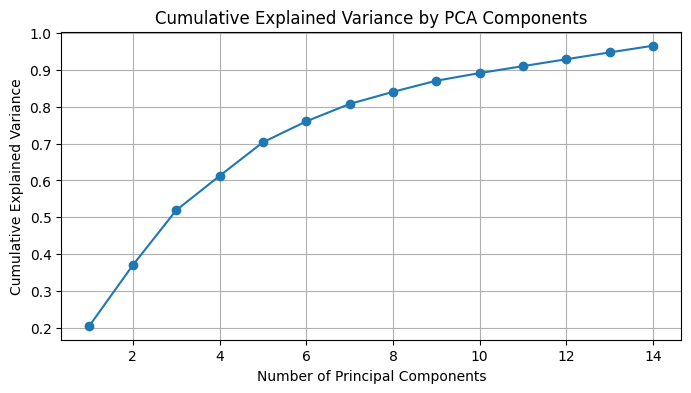

In [128]:
df['Work Experience'] = df['Work Experience'].replace(['0', '0.0'], '<1')

# ordinal categories for encoding
tier_of_employment_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
work_experience_categories = ['<1', '1-2', '2-3', '3-5', '5-10', '10+']

# categorical, numerical, and ordinal columns
categorical_features = ['Loan Category', 'Employment type', 'Home', 'Dependents', 'Social Profile', 'Number of loans']
numerical_features = ['Amount', 'Interest Rate', 'Total Income', 'Delinq_2yrs', 'Interest Received', 'Payment_to_Principal_Ratio']
ordinal_features = ['Tier of Employment', 'Work Experience']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[tier_of_employment_categories, work_experience_categories]), ordinal_features),
        ('categorical', OneHotEncoder(drop='first'), categorical_features),  # One-hot encode categorical variables
        ('numerical', StandardScaler(), numerical_features)  # Scale numerical variables
    ]
)

# Apply the preprocessing pipeline
df_transformed = preprocessor.fit_transform(df)

preprocessed_columns = (
    [f'{ordinal_features[i]}_Encoded' for i in range(len(ordinal_features))] +
    preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_features).tolist() +
    numerical_features
)

df_transformed = pd.DataFrame(df_transformed, columns=preprocessed_columns)

# Apply PCA to the transformed dataset, retaining 95% of the variance
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(df_transformed)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


 Capturing more variance generally helps in preserving important information for model training as the more information about the original dataset is kept, which can lead to better model performance.

Approximately 12 to 14 components will be selected providing around 90% or more of the variance, based on the cumulative explained variance plot

Number of components chosen: 11
Explained variance ratio of components: [0.2063226  0.16408182 0.14866912 0.093085   0.09114465 0.05678908
 0.04713941 0.0327828  0.03018586 0.02071945 0.01879423]


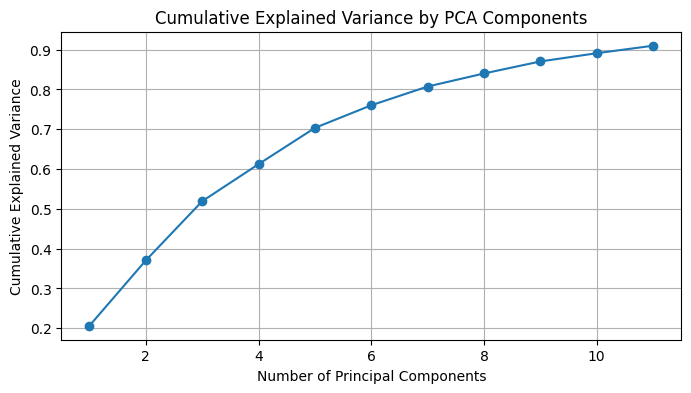

In [129]:
# Apply PCA to retain components that explain 90% variance
pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(df_transformed)

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

print(f"Number of components chosen: {pca.n_components_}")
print(f"Explained variance ratio of components: {pca.explained_variance_ratio_}")

explained_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid()
plt.grid(True)
plt.show()

The cumulative explained variance plot confirms that 11 components capture around 90% of the variance. This suggests that 11 principal components should provide a good balance between dimensionality reduction and retaining important information from the original dataset.

In PCA, the features that contribute to each principal component are captured in the PCA loadings, but the principal components themselves don’t retain the original feature names, as they are combinations of the original features. Breakdown of how each original feature contributes to each principal component gives a clearer idea of which features are driving the most important sources of variability in the data.



Top 5 contributing features to PC1:
Work Experience_Encoded       0.863948
Interest Rate                 0.271570
Tier of Employment_Encoded    0.174898
Total Income                  0.139859
Delinq_2yrs                   0.046587
Name: PC1, dtype: float64

Top 5 contributing features to PC2:
Work Experience_Encoded      0.492438
Interest Received            0.476980
Amount                       0.298693
Home_rent                    0.071837
Loan Category_Credit Card    0.032446
Name: PC2, dtype: float64

Top 5 contributing features to PC3:
Amount                        0.566992
Interest Rate                 0.462688
Tier of Employment_Encoded    0.340192
Home_rent                     0.161695
Payment_to_Principal_Ratio    0.107022
Name: PC3, dtype: float64

Top 5 contributing features to PC4:
Payment_to_Principal_Ratio    0.825653
Delinq_2yrs                   0.505802
Interest Received             0.235026
Work Experience_Encoded       0.058649
Loan Category_Other           0.007240

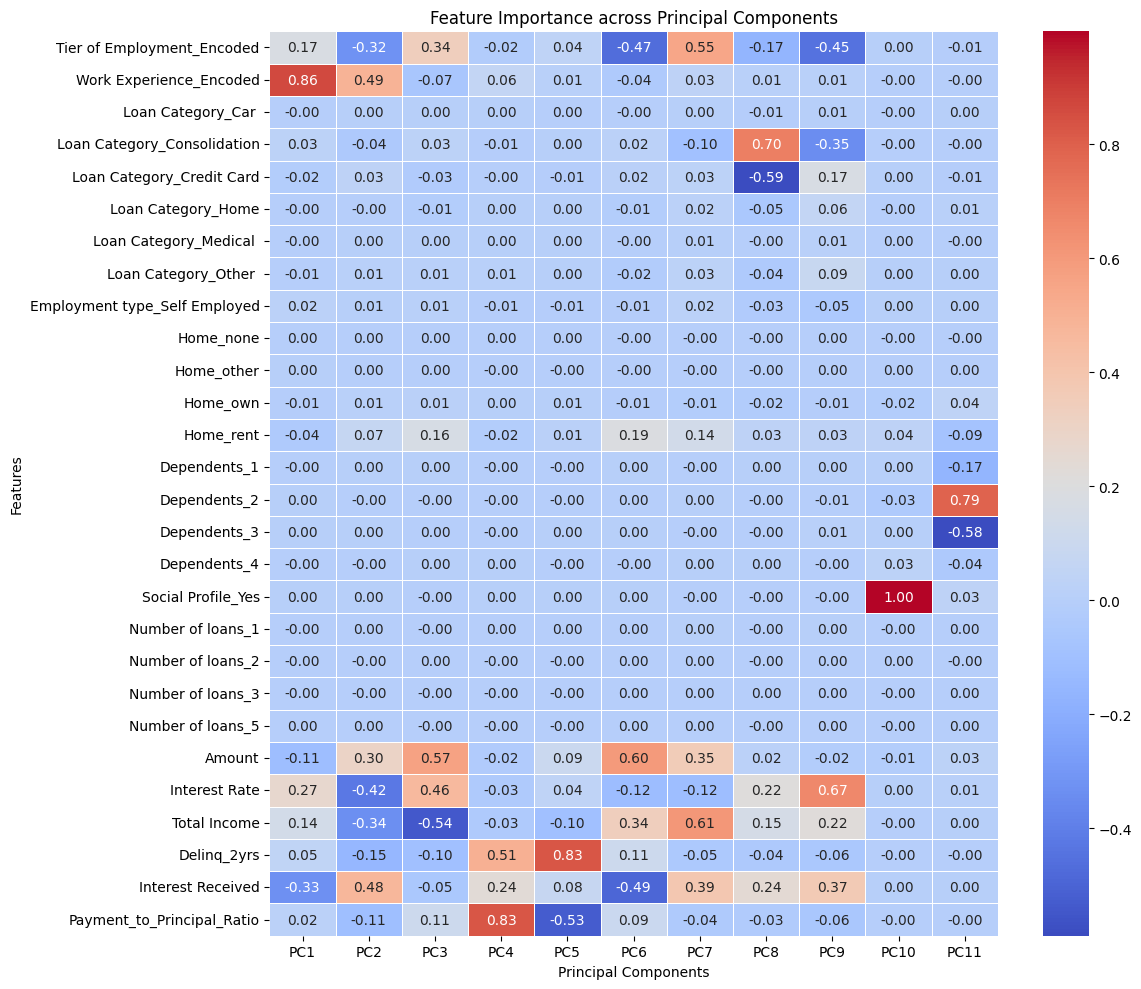

In [130]:
pca_loadings = pd.DataFrame(pca.components_, columns=df_transformed.columns)
pca_loadings.index = [f'PC{i+1}' for i in range(pca.n_components_)]

for i in range(pca.n_components_):
    print(f"\nTop 5 contributing features to PC{i+1}:")
    print(pca_loadings.iloc[i].sort_values(ascending=False).head(5))

plt.figure(figsize=(12, 10))
sns.heatmap(pca_loadings.T, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title("Feature Importance across Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Assuming df_transformed contains the final PCA-transformed dataset
# y is the target column, 'Defaulter'

y = df['Defaulter'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

cv_results = {}
roc_auc = make_scorer(roc_auc_score)

# Perform cross-validation for each model
for model_name, model in models.items():
    print(f"Performing cross-validation for {model_name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=roc_auc)
    cv_results[model_name] = scores
    print(f"Mean ROC AUC Score: {scores.mean():.4f} | Standard Deviation: {scores.std():.4f}")

cv_results_df = pd.DataFrame(cv_results)
print("\nCross-Validation Results (ROC AUC scores for 5-fold cross-validation):")
print(cv_results_df)

Performing cross-validation for Logistic Regression...
Mean ROC AUC Score: 0.6439 | Standard Deviation: 0.0075
Performing cross-validation for Random Forest...
Mean ROC AUC Score: 0.6783 | Standard Deviation: 0.0055
Performing cross-validation for XGBoost...
Mean ROC AUC Score: 0.7189 | Standard Deviation: 0.0047

Cross-Validation Results (ROC AUC scores for 5-fold cross-validation):
   Logistic Regression  Random Forest   XGBoost
0             0.649424       0.681197  0.719945
1             0.653060       0.683005  0.723709
2             0.638753       0.675664  0.715457
3             0.645743       0.682864  0.723724
4             0.632310       0.668761  0.711618


In [136]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Split the data (Ensure y is properly encoded as binary)
X_train, X_test, y_train, y_test = train_test_split(pca_df, df['Defaulter'].astype(int), test_size=0.3, random_state=42)

# Step 2: Define objective functions for each model with narrower search space and early stopping
def objective_log_reg(trial):
    C = trial.suggest_loguniform('C', 1e-2, 1e2)  # Narrowed range for faster search
    penalty = trial.suggest_categorical('penalty', ['l2'])  # Restricting to L2 for simplicity
    solver = trial.suggest_categorical('solver', ['liblinear'])  # Only 'liblinear' for speed

    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=500)

    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()  # Reduced CV folds to 3
    return score

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)  # Limited range for faster tuning
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Reduced depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()  # Reduced CV folds to 3
    return score

def objective_xgb(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)  # Limited range
    max_depth = trial.suggest_int('max_depth', 3, 10)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()  # Reduced CV folds to 3
    return score

# Step 3: Optimize using Optuna's TPE Sampler and Early Stopping
sampler = TPESampler(seed=42)  # TPE sampler for efficiency

# Optimize Logistic Regression
log_reg_study = optuna.create_study(direction='maximize', sampler=sampler, pruner=optuna.pruners.MedianPruner())
log_reg_study.optimize(objective_log_reg, n_trials=20)  # Reduced number of trials

print(f"Best parameters for Logistic Regression: {log_reg_study.best_params}")
print(f"Best ROC AUC score for Logistic Regression: {log_reg_study.best_value}")

# Optimize Random Forest
rf_study = optuna.create_study(direction='maximize', sampler=sampler, pruner=optuna.pruners.MedianPruner())
rf_study.optimize(objective_rf, n_trials=20)  # Reduced number of trials

print(f"Best parameters for Random Forest: {rf_study.best_params}")
print(f"Best ROC AUC score for Random Forest: {rf_study.best_value}")

# Optimize XGBoost with early stopping
xgb_study = optuna.create_study(direction='maximize', sampler=sampler, pruner=optuna.pruners.MedianPruner())
xgb_study.optimize(objective_xgb, n_trials=20)  # Reduced number of trials

print(f"Best parameters for XGBoost: {xgb_study.best_params}")
print(f"Best ROC AUC score for XGBoost: {xgb_study.best_value}")

# Step 4: Train the models with the best parameters from Optuna and evaluate
best_log_reg = LogisticRegression(**log_reg_study.best_params, max_iter=500)
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42)
best_xgb = xgb.XGBClassifier(**xgb_study.best_params, eval_metric='auc', use_label_encoder=False, random_state=42)

models = {'Logistic Regression': best_log_reg, 'Random Forest': best_rf, 'XGBoost': best_xgb}

# Fit the models and evaluate on the test set
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{model_name} - ROC AUC Score: {roc_auc}")

Best parameters for Logistic Regression: {'C': 0.0535472270046421, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC score for Logistic Regression: 0.8330882880607872
Best parameters for Random Forest: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}
Best ROC AUC score for Random Forest: 0.8421945490377928
Best parameters for XGBoost: {'learning_rate': 0.050099951218549266, 'n_estimators': 500, 'max_depth': 10, 'colsample_bytree': 0.9272607495368129, 'subsample': 0.9472908016985484}
Best ROC AUC score for XGBoost: 0.9051119531801358

Evaluating Logistic Regression...
Logistic Regression - ROC AUC Score: 0.6240260103496267

Evaluating Random Forest...
Random Forest - ROC AUC Score: 0.6118177664358743

Evaluating XGBoost...
XGBoost - ROC AUC Score: 0.7334153472416374


In [137]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Step 1: Split the data (Ensure y is properly encoded as binary)
X_train, X_test, y_train, y_test = train_test_split(pca_df, df['Defaulter'].astype(int), test_size=0.3, random_state=42)

# Define the stratified K-fold cross-validator
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models with the best parameters from Optuna
best_log_reg = LogisticRegression(C=0.0535472270046421, penalty='l2', solver='liblinear', max_iter=500)
best_rf = RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_split=8, min_samples_leaf=5, random_state=42)
best_xgb = xgb.XGBClassifier(
    learning_rate=0.050099951218549266,
    n_estimators=500,
    max_depth=10,
    colsample_bytree=0.9272607495368129,
    subsample=0.9472908016985484,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Dictionary to hold the models
models = {
    'Logistic Regression': best_log_reg,
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

# Evaluate the models using Stratified K-Fold Cross-Validation and report ROC AUC scores
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} using Stratified Cross-Validation...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring='roc_auc')
    print(f"{model_name} - Mean ROC AUC Score: {cv_scores.mean():.4f} | Standard Deviation: {cv_scores.std():.4f}")

# Step 4: Fit the models on the full training data and evaluate on the test data
for model_name, model in models.items():
    print(f"\nTraining and Evaluating {model_name} on Test Data...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{model_name} - ROC AUC Score on Test Data: {roc_auc:.4f}")


Evaluating Logistic Regression using Stratified Cross-Validation...
Logistic Regression - Mean ROC AUC Score: 0.8330 | Standard Deviation: 0.0037

Evaluating Random Forest using Stratified Cross-Validation...
Random Forest - Mean ROC AUC Score: 0.8436 | Standard Deviation: 0.0037

Evaluating XGBoost using Stratified Cross-Validation...
XGBoost - Mean ROC AUC Score: 0.9070 | Standard Deviation: 0.0040

Training and Evaluating Logistic Regression on Test Data...
Logistic Regression - ROC AUC Score on Test Data: 0.6240

Training and Evaluating Random Forest on Test Data...
Random Forest - ROC AUC Score on Test Data: 0.6118

Training and Evaluating XGBoost on Test Data...
XGBoost - ROC AUC Score on Test Data: 0.7334


In [138]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler

# Objective function for fine-tuning XGBoost
def objective_xgb_fine_tune(trial):
    # Hyperparameter suggestions for fine-tuning
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 400, 700, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
    subsample = trial.suggest_float('subsample', 0.8, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 5)

    # XGBoost model with tuned parameters
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42
    )

    # Perform stratified cross-validation
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5).mean()
    return score

# Sampler for the optimization
sampler = TPESampler(seed=42)

# Create a study and optimize XGBoost
xgb_fine_tune_study = optuna.create_study(direction='maximize', sampler=sampler)
xgb_fine_tune_study.optimize(objective_xgb_fine_tune, n_trials=50)

# Print the best parameters and best ROC AUC score after fine-tuning
print(f"Best parameters for fine-tuned XGBoost: {xgb_fine_tune_study.best_params}")
print(f"Best ROC AUC score for fine-tuned XGBoost: {xgb_fine_tune_study.best_value}")

# Train and evaluate the fine-tuned XGBoost model
best_xgb_fine_tuned = xgb.XGBClassifier(**xgb_fine_tune_study.best_params, eval_metric='auc', use_label_encoder=False, random_state=42)

# Train the model on the full training set and evaluate on test set
best_xgb_fine_tuned.fit(X_train, y_train)
y_pred = best_xgb_fine_tuned.predict(X_test)
roc_auc_fine_tuned = roc_auc_score(y_test, y_pred)

print(f"Fine-tuned XGBoost - ROC AUC Score on Test Data: {roc_auc_fine_tuned}")

Best parameters for fine-tuned XGBoost: {'learning_rate': 0.03416417525320409, 'n_estimators': 700, 'max_depth': 11, 'colsample_bytree': 0.939377899447388, 'subsample': 0.8433755557879988, 'gamma': 0.5657334597619516, 'reg_lambda': 1.0816662041793847, 'reg_alpha': 3.818786226378269, 'scale_pos_weight': 1.6672950150852266}
Best ROC AUC score for fine-tuned XGBoost: 0.911969686291687
Fine-tuned XGBoost - ROC AUC Score on Test Data: 0.754684277547387


In [139]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 37.6 MB/s eta 0:00:00


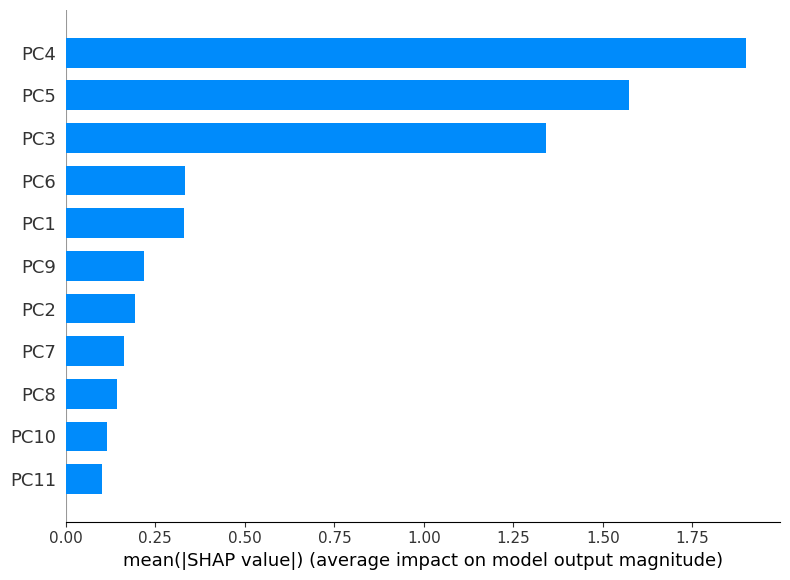

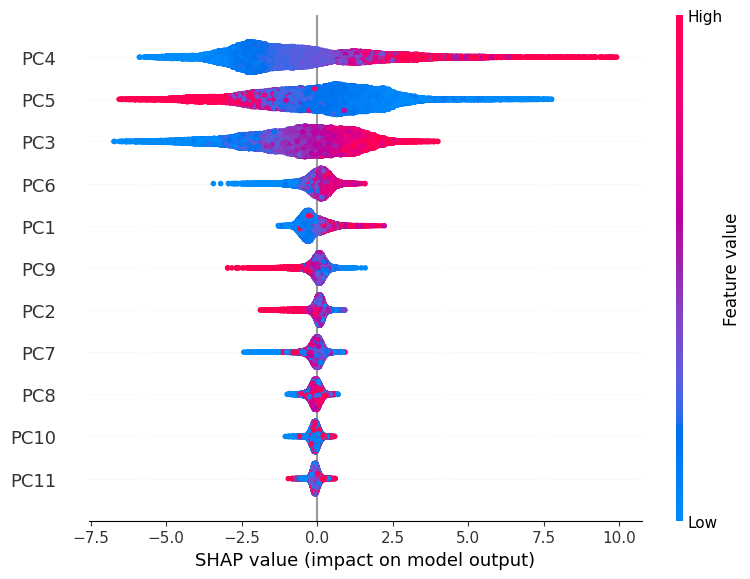

In [140]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 1: Initialize SHAP Explainer
explainer = shap.TreeExplainer(best_xgb)

# Step 2: Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Step 3: Summary plot
# This plot shows the impact of each feature on the model's output
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# Step 4: Detailed feature importance plot
# The summary plot with all features displayed
shap.summary_plot(shap_values, X_test)

# Step 5: Force plot for a single instance
# Visualizes how each feature contributes to the prediction for a single data point
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])